In [1]:
import pandas as pd
import numpy as np 

### load the data

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_target = pd.read_csv('sample_submission.csv')

In [3]:
df_train.isna().sum()


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [4]:
df_test.isna().sum()


id             0
keyword       26
location    1105
text           0
dtype: int64

In [5]:
df_target.isna().sum()


id        0
target    0
dtype: int64

In [6]:
df_train.keyword = df_train.keyword.fillna(df_train.keyword.mode()[0])
df_test.keyword = df_test.keyword.fillna(df_test.keyword.mode()[0])
df_train = df_train.dropna()
df_test = df_test.dropna()

In [7]:
df_test['text'] = df_test['keyword'] + " "+df_test['location'] + " "+df_test['text']
df_train['text'] = df_train['keyword'] + " "+df_train['location'] + " "+df_train['text']

In [8]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [9]:
df_test = pd.merge(df_test, df_target, on='id')

###  Text Clean 

In [10]:
# Libraries and packages for text (pre-)processing 
import string
import re
import nltk

In [11]:
df_train["clean_text"] = df_train["text"].apply(lambda x: x.lower())
df_test["clean_text"] = df_test["text"].apply(lambda x: x.lower())


In [12]:
!pip install contractions

In [13]:
import contractions

In [14]:
df_train["clean_text"] = df_train["clean_text"].apply(lambda x: contractions.fix(x))
df_test["clean_text"] = df_test["clean_text"].apply(lambda x: contractions.fix(x))


In [15]:
df_train["clean_text"]

0       ablaze birmingham @bbcmtd wholesale markets ab...
1       ablaze est. september 2012 - bristol we always...
2       ablaze africa #africanbaze: breaking news:nige...
3       ablaze philadelphia, pa crying out for more! s...
4       ablaze london, uk on plus side look at the sky...
                              ...                        
5075    wrecked tn on the bright side i wrecked http:/...
5076    wrecked #newcastleupontyne #uk @widda16 ... he...
5077    wrecked vancouver, canada three days off from ...
5078    wrecked london  #fx #forex #trading cramer: ig...
5079    wrecked lincoln @engineshed great atmosphere a...
Name: clean_text, Length: 5080, dtype: object

In [16]:
print(df_train["text"][1])
print(df_train["clean_text"][1])

ablaze Est. September 2012 - Bristol We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw
ablaze est. september 2012 - bristol we always try to bring the heavy. #metal #rt http://t.co/yao1e0xngw


In [17]:
print(df_test["text"][1])
print(df_test["clean_text"][1])

ablaze Niall's place | SAF 12 SQUAD | @sunkxssedharry will you wear shorts for race ablaze ?
ablaze niall's place | saf 12 squad | @sunkxssedharry will you wear shorts for race ablaze ?


In [18]:
def remove_URL(text):
    """
        Remove URLs from a sample string
    """
    return re.sub(r"https?://\S+|www\.\S+", "", text)



def remove_html(text):
    """
        Remove the html in sample text
    """
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)


def remove_non_ascii(text):
    """
        Remove non-ASCII characters 
    """
    return re.sub(r'[^\x00-\x7f]',r'', text) # or ''.join([x for x in text if x in string.printable]) 


def remove_punct(text):
    """
        Remove the punctuation
    """
#     return re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', "", text)
    return text.translate(str.maketrans('', '', string.punctuation))

In [19]:
%time
# apply Remove URLs
df_train["clean_text"] = df_train["clean_text"].apply(lambda x: remove_URL(x))
df_test["clean_text"] = df_test["clean_text"].apply(lambda x: remove_URL(x))

# apply Remove html
df_train["clean_text"] = df_train["clean_text"].apply(lambda x: remove_html(x))
df_test["clean_text"] = df_test["clean_text"].apply(lambda x: remove_html(x))

# apply Remove non-ASCII
df_train["clean_text"] = df_train["clean_text"].apply(lambda x: remove_non_ascii(x))
df_test["clean_text"] = df_test["clean_text"].apply(lambda x: remove_non_ascii(x))

# apply Remove punctuation
df_train["clean_text"] = df_train["clean_text"].apply(lambda x: remove_punct(x))
df_test["clean_text"] = df_test["clean_text"].apply(lambda x: remove_punct(x))

CPU times: user 3 μs, sys: 1 μs, total: 4 μs
Wall time: 10.3 μs


###  Text Preprocessing 

In [20]:
%time
# Tokenizing the tweet base texts.
from nltk.tokenize import word_tokenize
nltk.download('punkt')
df_train['tokenized'] = df_train['clean_text'].apply(word_tokenize)
df_test['tokenized'] = df_test['clean_text'].apply(word_tokenize)


CPU times: user 3 μs, sys: 1 μs, total: 4 μs
Wall time: 7.87 μs


[nltk_data] Downloading package punkt to /home/aboud/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
# Removing stopwords.
nltk.download("stopwords")
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))
df_train['stopwords_removed'] = df_train['tokenized'].apply(lambda x: [word for word in x if word not in stop])
df_test['stopwords_removed'] = df_test['tokenized'].apply(lambda x: [word for word in x if word not in stop])


[nltk_data] Downloading package stopwords to /home/aboud/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
from nltk.stem import SnowballStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import PorterStemmer


def porter_stemmer(text):
    """
        Stem words in list of tokenized words with PorterStemmer
    """
    stemmer = nltk.PorterStemmer()
    stems = [stemmer.stem(i) for i in text]
    return stems

def lancaster_stemmer(text):
    """
        Stem words in list of tokenized words with LancasterStemmer
    """
    stemmer = nltk.LancasterStemmer()
    stems = [stemmer.stem(i) for i in text]
    return stems

def snowball_stemmer(text):
    """
        Stem words in list of tokenized words with SnowballStemmer
    """
    stemmer = nltk.SnowballStemmer("english")
    stems = [stemmer.stem(i) for i in text]
    return stems




In [23]:
%time 

df_train['porter_stemmer'] = df_train['stopwords_removed'].apply(lambda x: porter_stemmer(x))
df_test['porter_stemmer'] = df_test['stopwords_removed'].apply(lambda x: porter_stemmer(x))

df_train['lancaster_stemmer'] = df_train['stopwords_removed'].apply(lambda x: lancaster_stemmer(x))
df_test['lancaster_stemmer'] = df_test['stopwords_removed'].apply(lambda x: lancaster_stemmer(x))

df_train['snowball_stemmer'] = df_train['stopwords_removed'].apply(lambda x: snowball_stemmer(x))
df_test['snowball_stemmer'] = df_test['stopwords_removed'].apply(lambda x: snowball_stemmer(x))


CPU times: user 5 μs, sys: 1 μs, total: 6 μs
Wall time: 11.7 μs


In [24]:
# Uncomments if u havent download it yet

nltk.download('brown')
nltk.download('wordnet')

from nltk.corpus import wordnet
from nltk.corpus import brown

wordnet_map = {"N":wordnet.NOUN, 
               "V":wordnet.VERB, 
               "J":wordnet.ADJ, 
               "R":wordnet.ADV
              }
    
train_sents = brown.tagged_sents(categories='news')

# fallback for unknown words.
t0 = nltk.DefaultTagger('NN')

# Creates a unigram tagger
t1 = nltk.UnigramTagger(train_sents, backoff=t0)

# Creates a bigram tagger
t2 = nltk.BigramTagger(train_sents, backoff=t1)

def pos_tag_wordnet(text, pos_tag_type="pos_tag"):
    """
        Create pos_tag with wordnet format
    """
    pos_tagged_text = t2.tag(text)
    
    # map the pos tagging output with wordnet output 
    pos_tagged_text = [(word, wordnet_map.get(pos_tag[0])) if pos_tag[0] in wordnet_map.keys() else (word, wordnet.NOUN) for (word, pos_tag) in pos_tagged_text ]
    return pos_tagged_text

[nltk_data] Downloading package brown to /home/aboud/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package wordnet to /home/aboud/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [25]:
%time 
# Apply part of speech tag without wordnet on train and test data 
df_train['combined_postag_wnet'] = df_train['stopwords_removed'].apply(lambda x: pos_tag_wordnet(x))
df_test['combined_postag_wnet'] = df_test['stopwords_removed'].apply(lambda x: pos_tag_wordnet(x))


CPU times: user 7 μs, sys: 0 ns, total: 7 μs
Wall time: 15 μs


In [26]:
from nltk.stem import WordNetLemmatizer

def lemmatize_word(text):
    """
        Lemmatize the tokenized words
    """

    lemmatizer = WordNetLemmatizer()
    lemma = [lemmatizer.lemmatize(word, tag) for word, tag in text]
    return lemma

In [27]:
# Test without POS Tagging
lemmatizer = WordNetLemmatizer()

df_train['lemmatize_word_wo_pos'] = df_train['stopwords_removed'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
df_train['lemmatize_word_wo_pos'] = df_train['lemmatize_word_wo_pos'].apply(lambda x: [word for word in x if word not in stop]) # double check to remove stop words

df_test['lemmatize_word_wo_pos'] = df_test['stopwords_removed'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
df_test['lemmatize_word_wo_pos'] = df_test['lemmatize_word_wo_pos'].apply(lambda x: [word for word in x if word not in stop]) # double check to remove stop words



In [28]:
%time 

# Test with POS Tagging
lemmatizer = WordNetLemmatizer()

df_train['lemmatize_word_w_pos'] = df_train['combined_postag_wnet'].apply(lambda x: lemmatize_word(x))
df_train['lemmatize_word_w_pos'] = df_train['lemmatize_word_w_pos'].apply(lambda x: [word for word in x if word not in stop]) # double check to remove stop words
df_train['lemmatize_text'] = [' '.join(map(str, l)) for l in df_train['lemmatize_word_w_pos']] # join back to text


df_test['lemmatize_word_w_pos'] = df_test['combined_postag_wnet'].apply(lambda x: lemmatize_word(x))
df_test['lemmatize_word_w_pos'] = df_test['lemmatize_word_w_pos'].apply(lambda x: [word for word in x if word not in stop]) # double check to remove stop words
df_test['lemmatize_text'] = [' '.join(map(str, l)) for l in df_test['lemmatize_word_w_pos']] # join back to text


CPU times: user 5 μs, sys: 0 ns, total: 5 μs
Wall time: 10.7 μs


In [29]:


print(df_train["text"][31])
print(df_train["combined_postag_wnet"][31])
print(df_train["lemmatize_word_wo_pos"][31])
print(df_train["lemmatize_word_w_pos"][31])



accident Santa Clara, CA Accident center lane blocked in #SantaClara on US-101 NB before Great America Pkwy #BayArea #Traffic http://t.co/pmlOhZuRWR
[('accident', 'n'), ('santa', 'n'), ('clara', 'n'), ('ca', 'n'), ('accident', 'n'), ('center', 'n'), ('lane', 'n'), ('blocked', 'v'), ('santaclara', 'n'), ('us101', 'n'), ('nb', 'n'), ('great', 'a'), ('america', 'n'), ('pkwy', 'n'), ('bayarea', 'n'), ('traffic', 'n')]
['accident', 'santa', 'clara', 'ca', 'accident', 'center', 'lane', 'blocked', 'santaclara', 'us101', 'nb', 'great', 'america', 'pkwy', 'bayarea', 'traffic']
['accident', 'santa', 'clara', 'ca', 'accident', 'center', 'lane', 'block', 'santaclara', 'us101', 'nb', 'great', 'america', 'pkwy', 'bayarea', 'traffic']


In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def cv(train , test,  ngram = 1, MAX_NB_WORDS = 75000):
    count_vectorizer = CountVectorizer(ngram_range = (ngram, ngram), max_features = MAX_NB_WORDS)
    train_vectorize = count_vectorizer.fit_transform(train).toarray()
    test_vectorize =  count_vectorizer.transform(test).toarray()
#    print("count vectorize with", str(np.array(train_vectorize).shape[1]), "features")
#    print("count vectorize with", str(np.array(test_vectorize).shape[1]), "features")
    
    return train_vectorize , test_vectorize , count_vectorizer

def tf(train , test):
    tf_vectorizer = TfidfVectorizer()
    train_vectorize = tf_vectorizer.fit_transform(train).toarray()
    test_vectorize = tf_vectorizer.transform(test).toarray()
    columns = tf_vectorizer.get_feature_names_out()
    return train_vectorize , test_vectorize , tf_vectorizer


In [31]:
for col in df_train.columns[5:]:
    print(col + " " , type(df_train[col][0][0]))
    print(col + " " , type(df_train[col][0]))
    

clean_text  <class 'str'>
clean_text  <class 'str'>
tokenized  <class 'str'>
tokenized  <class 'list'>
stopwords_removed  <class 'str'>
stopwords_removed  <class 'list'>
porter_stemmer  <class 'str'>
porter_stemmer  <class 'list'>
lancaster_stemmer  <class 'str'>
lancaster_stemmer  <class 'list'>
snowball_stemmer  <class 'str'>
snowball_stemmer  <class 'list'>
combined_postag_wnet  <class 'tuple'>
combined_postag_wnet  <class 'list'>
lemmatize_word_wo_pos  <class 'str'>
lemmatize_word_wo_pos  <class 'list'>
lemmatize_word_w_pos  <class 'str'>
lemmatize_word_w_pos  <class 'list'>
lemmatize_text  <class 'str'>
lemmatize_text  <class 'str'>


In [32]:
# conditions we need to ignore for now 
# 1 - type(df_train[col][0][0] == "tuple" 

In [33]:
# ok after we look to the target value counts 
# Note : the target in test dataframe has only 1 unique value and its : 0
# there is no ones 

# we decided to concate the test dataframe and the train dataframe 
# to create one dataframe and then create our own test by split them 

df = pd.concat([df_train, df_test], axis=0)

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split


from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt 

In [35]:
y_train = df["target"] 
y_test = df_test["target"]

In [37]:
# Create a dictionary of lists for each model
model_accuracies = {
    "Random Forest": [],
    "Logistic Regression": [],
    "Gaussian NB": [],
    "KNeighbors Classifier": [],
    "Decision Tree Classifier": []
}

y = df["target"] 

for col in df_train.columns[5:]:
    # We will ignore that column for now
    if type(df_train[col][0][0]) == tuple:
        continue

    # Join words
    if type(df_train[col][0]) == list:
        X = df[col].apply(lambda x: " ".join(x))
    else:
        X = df[col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Convert them to numbers using tf 
    X_train, X_test, vc_1gram = tf(X_train, X_test)


    X_train, y_train = SMOTE().fit_resample(X_train, y_train) 
    
    
    # Random Forest
    RandomForest_model = RandomForestClassifier()
    RandomForest_model.fit(X_train, y_train)
    y_pred_rf = RandomForest_model.predict(X_test)
    RandomForest_model_accuracy = accuracy_score(y_test, y_pred_rf)
    model_accuracies["Random Forest"].append(RandomForest_model_accuracy)

    # Logistic Regression
    LogisticRegression_model = LogisticRegression()
    LogisticRegression_model.fit(X_train, y_train)
    y_pred_lg = LogisticRegression_model.predict(X_test)
    LogisticRegression_model_accuracy = accuracy_score(y_test, y_pred_lg)
    model_accuracies["Logistic Regression"].append(LogisticRegression_model_accuracy)

    # Gaussian NB
    GaussianNB_model = GaussianNB()
    GaussianNB_model.fit(X_train, y_train)
    y_pred_gnb = GaussianNB_model.predict(X_test)
    GaussianNB_model_accuracy = accuracy_score(y_test, y_pred_gnb)
    model_accuracies["Gaussian NB"].append(GaussianNB_model_accuracy)

    # KNeighbors Classifier
    KNeighborsClassifier_model = RandomForestClassifier()
    KNeighborsClassifier_model.fit(X_train, y_train)
    y_pred_knn = KNeighborsClassifier_model.predict(X_test)
    KNeighborsClassifier_model_accuracy = accuracy_score(y_test, y_pred_knn)
    model_accuracies["KNeighbors Classifier"].append(KNeighborsClassifier_model_accuracy)

    # Decision Tree Classifier
    DecisionTreeClassifier_model = DecisionTreeClassifier()
    DecisionTreeClassifier_model.fit(X_train, y_train)
    y_pred_dt = DecisionTreeClassifier_model.predict(X_test)
    DecisionTreeClassifier_model_accuracy = accuracy_score(y_test, y_pred_dt)
    model_accuracies["Decision Tree Classifier"].append(DecisionTreeClassifier_model_accuracy)

# Convert the dictionary to a pandas DataFrame
model_accuracies_df = pd.DataFrame(model_accuracies)

# Transpose the DataFrame
model_accuracies_df = model_accuracies_df.T

# Rename the columns
model_accuracies_df.columns = df_train.columns[5:-4].tolist() + df_train.columns[-3:].tolist()

In [38]:
# Create a dictionary of lists for each model
model_accuracies = {
    "Random Forest": [],
    "Logistic Regression": [],
    "Gaussian NB": [],
    "KNeighbors Classifier": [],
    "Decision Tree Classifier": []
}

# set y train and y_test  
y_train = df_train["target"] 
y_test = df_test["target"]

for col in df_train.columns[5:]:
    # we will ignore that column for now 
    if type(df_train[col][0][0]) == tuple:
        continue
        
    # join words   
    if type(df_train[col][0]) == list:
        train = df_train[col].apply(lambda x : " ".join(x))
        test = df_test[col].apply(lambda x : " ".join(x))
    else:
        train = df_train[col]
        test = df_test[col]
    
    
    # let convert them to numbers using cv 
    X_train, X_test ,  vc_1gram = cv(train ,test , 1)
  
    # Random Forest
    RandomForest_model = RandomForestClassifier()
    RandomForest_model.fit(X_train, y_train)
    y_pred_rf = RandomForest_model.predict(X_test)
    RandomForest_model_accuracy = accuracy_score(y_test, y_pred_rf)
    model_accuracies["Random Forest"].append(RandomForest_model_accuracy)

    # Logistic Regression
    LogisticRegression_model = LogisticRegression()
    LogisticRegression_model.fit(X_train, y_train)
    y_pred_lg = LogisticRegression_model.predict(X_test)
    LogisticRegression_model_accuracy = accuracy_score(y_test, y_pred_lg)
    model_accuracies["Logistic Regression"].append(LogisticRegression_model_accuracy)

    # Gaussian NB
    GaussianNB_model = GaussianNB()
    GaussianNB_model.fit(X_train, y_train)
    y_pred_gnb = GaussianNB_model.predict(X_test)
    GaussianNB_model_accuracy = accuracy_score(y_test, y_pred_gnb)
    model_accuracies["Gaussian NB"].append(GaussianNB_model_accuracy)

    # KNeighbors Classifier
    KNeighborsClassifier_model = RandomForestClassifier()
    KNeighborsClassifier_model.fit(X_train, y_train)
    y_pred_knn = KNeighborsClassifier_model.predict(X_test)
    KNeighborsClassifier_model_accuracy = accuracy_score(y_test, y_pred_knn)
    model_accuracies["KNeighbors Classifier"].append(KNeighborsClassifier_model_accuracy)

    # Decision Tree Classifier
    DecisionTreeClassifier_model = DecisionTreeClassifier()
    DecisionTreeClassifier_model.fit(X_train, y_train)
    y_pred_dt = DecisionTreeClassifier_model.predict(X_test)
    DecisionTreeClassifier_model_accuracy = accuracy_score(y_test, y_pred_dt)
    model_accuracies["Decision Tree Classifier"].append(DecisionTreeClassifier_model_accuracy)

# Convert the dictionary to a pandas DataFrame
model_accuracies_df_train_and_test = pd.DataFrame(model_accuracies)

# Transpose the DataFrame
model_accuracies_df_train_and_test = model_accuracies_df_train_and_test.T

# Rename the columns
model_accuracies_df_train_and_test.columns = df_train.columns[5:-4].tolist() + df_train.columns[-3:].tolist()

In [39]:
model_accuracies_df

,clean_text,tokenized,stopwords_removed,porter_stemmer,lancaster_stemmer,snowball_stemmer,lemmatize_word_wo_pos,lemmatize_word_w_pos,lemmatize_text
Random Forest,0.735497,0.746547,0.747238,0.743785,0.745856,0.729972,0.763122,0.738260,0.743094
Logistic Regression,0.742403,0.738950,0.743094,0.746547,0.745166,0.721685,0.754834,0.742403,0.725138
Gaussian NB,0.611878,0.619475,0.607044,0.610497,0.605663,0.598757,0.607735,0.607735,0.601519
KNeighbors Classifier,0.735497,0.749309,0.743785,0.745166,0.741022,0.739641,0.762431,0.736878,0.747928
Decision Tree Classifier,0.671271,0.683702,0.688536,0.690608,0.680249,0.678177,0.703039,0.680249,0.685083


In [40]:
model_accuracies_df_train_and_test

,clean_text,tokenized,stopwords_removed,porter_stemmer,lancaster_stemmer,snowball_stemmer,lemmatize_word_wo_pos,lemmatize_word_w_pos,lemmatize_text
Random Forest,0.708990,0.706673,0.668211,0.650139,0.645505,0.650139,0.665894,0.664041,0.669138
Logistic Regression,0.613994,0.613068,0.631140,0.622799,0.621872,0.620482,0.626506,0.626043,0.626043
Gaussian NB,0.409639,0.409639,0.409639,0.391566,0.365153,0.389713,0.399444,0.388323,0.388323
KNeighbors Classifier,0.705746,0.709453,0.671918,0.654773,0.645968,0.662651,0.670065,0.667748,0.670065
Decision Tree Classifier,0.591288,0.598239,0.582947,0.581094,0.576923,0.591288,0.607044,0.587118,0.590361


* so as we see in `model_accuracies_df` random forest got highest accuracy in `lemmatize_word_wo_pos` column
*  in `model_accuracies_df_train_and_test` knn got the highest in `clean text`
*  i should try them with `cv` and `tf` for each one but its take a long time so we will ignore it 

0.734251968503937


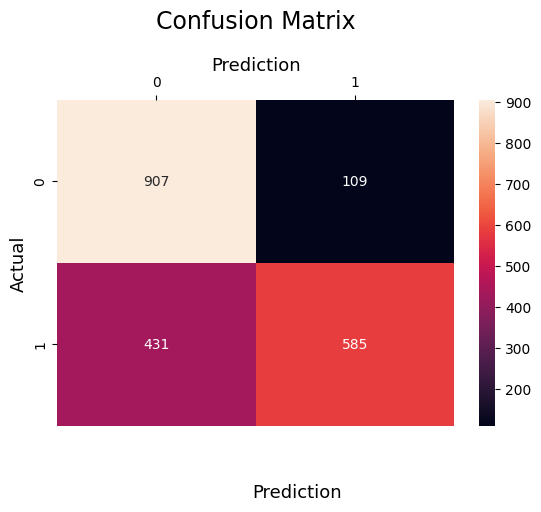

In [45]:
X = df["lemmatize_word_wo_pos"].apply(lambda x : " ".join(x))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Convert them to numbers using tf 
X_train, X_test, vc_1gram = tf(X_train, X_test)


X_train, y_train = SMOTE().fit_resample(X_train, y_train) 
X_test, y_test = SMOTE().fit_resample(X_test, y_test) 

# Random Forest
RandomForest_model = RandomForestClassifier()
RandomForest_model.fit(X_train, y_train)
y_pred_rf = RandomForest_model.predict(X_test)
RandomForest_model_accuracy = accuracy_score(y_test, y_pred_rf)

print(RandomForest_model_accuracy)
cm = confusion_matrix(y_test,y_pred_rf)

sns.heatmap(cm, annot=True, fmt='g', xticklabels=['0','1'], yticklabels=['0','1']) 
plt.ylabel('Actual', fontsize=13) 
plt.title('Confusion Matrix', fontsize=17, pad=20) 
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13) 
plt.gca().xaxis.tick_top() 
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

0.7287128712871287


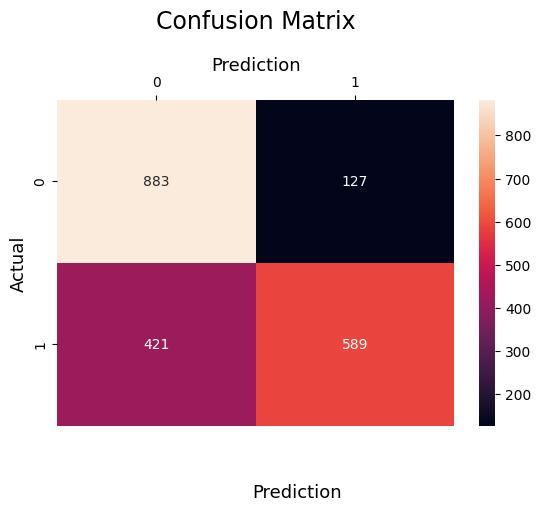

In [46]:
X = df["lemmatize_text"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Convert them to numbers using tf 
X_train, X_test, vc_1gram = tf(X_train, X_test)

X_train, y_train = SMOTE().fit_resample(X_train, y_train) 
X_test, y_test = SMOTE().fit_resample(X_test, y_test) 

# Random Forest
RandomForest_model = RandomForestClassifier()
RandomForest_model.fit(X_train, y_train)
y_pred_rf = RandomForest_model.predict(X_test)
RandomForest_model_accuracy = accuracy_score(y_test, y_pred_rf)

print(RandomForest_model_accuracy)
cm = confusion_matrix(y_test,y_pred_rf)

sns.heatmap(cm, annot=True, fmt='g', xticklabels=['0','1'], yticklabels=['0','1']) 
plt.ylabel('Actual', fontsize=13) 
plt.title('Confusion Matrix', fontsize=17, pad=20) 
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13) 
plt.gca().xaxis.tick_top() 
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

In [ ]:
## we should do like that for the column that we ignore it but it takes a long time so we will ignore it 
## maybe in one day we will do it 
## TODO
# words, pos_tags = zip(*data)
# vectorizer = CountVectorizer()
# vectorizer.fit(words)
# vocab = vectorizer.vocabulary_
# word_encodings = [vocab[word] for word in words]
# le = LabelEncoder()
# le.fit(pos_tags)
# pos_encodings = le.transform(pos_tags)
# X = list(zip(word_encodings, pos_encodings))
# y = [0, 1, 0]

# model = LogisticRegression()
# model.fit(X, y)

